# Samsung Stock Prediction

## Library

In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from matplotlib.pylab import rcParams
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

## Data Import

In [84]:
filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/005930.KS.csv'
df = pd.read_csv(filepath, index_col='Date', parse_dates=True)
ts = df['Close']
print(ts.head())
print(ts.shape)

Date
2000-01-04    6110.0
2000-01-05    5580.0
2000-01-06    5620.0
2000-01-07    5540.0
2000-01-10    5770.0
Name: Close, dtype: float64
(5187,)


## Check the data
### Visualization

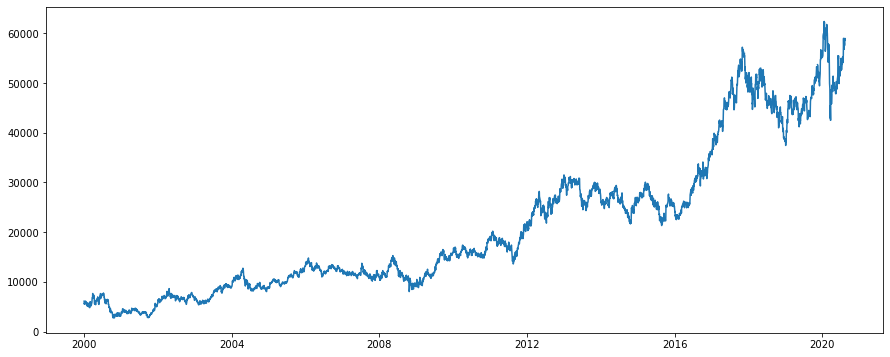

In [85]:
# 증가하는 추세
rcParams['figure.figsize'] = 15,6
plt.plot(ts)

### Missing Value

In [86]:
# check the missing value
print(ts[ts.isna()])
# interpolation
ts = ts.interpolate(method='time')

Date
2000-12-25   NaN
2001-01-23   NaN
2001-01-24   NaN
2001-01-25   NaN
2001-03-14   NaN
2005-01-03   NaN
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, dtype: float64


### Rolling Statistics

In [31]:
# Rolling Statistics
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

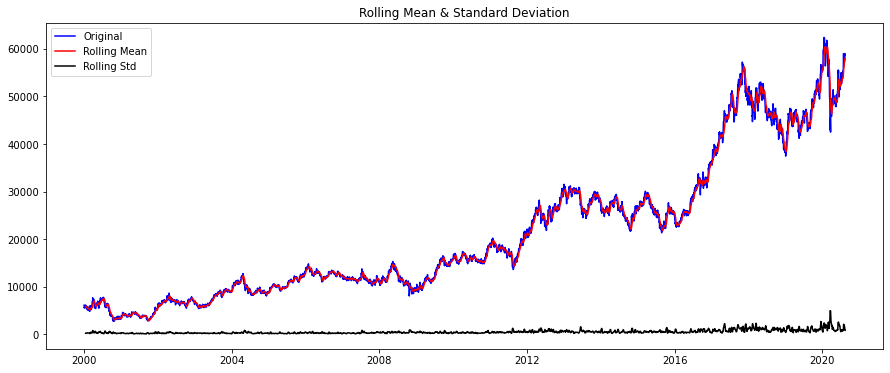

In [87]:
# 시간에 따라 평균 분석 패턴 변화하는 편. 딱히 패턴은 안보임.
plot_rolling_statistics(ts, window=12)

### Stationary 체크

In [37]:
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [88]:
# p-value를 보면 안정적이지 못한 시계열 (거의 1에 가까움)
augmented_dickey_fuller_test(ts)

Results of Dickey-Fuller Test:
Test Statistic                    0.569039
p-value                           0.986827
#Lags Used                       27.000000
Number of Observations Used    5159.000000
Critical Value (1%)              -3.431618
Critical Value (5%)              -2.862100
Critical Value (10%)             -2.567068
dtype: float64


### Stationary로 변환

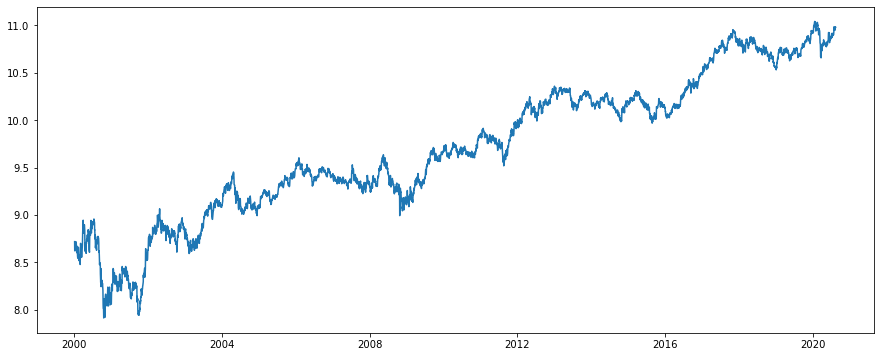

In [89]:
ts_log = np.log(ts)
plt.plot(ts_log)

In [90]:
# augmented dickey-fuller test로 확인.
# p-value 살짝 줄어듦.
augmented_dickey_fuller_test(ts_log)

Results of Dickey-Fuller Test:
Test Statistic                   -0.687281
p-value                           0.850017
#Lags Used                        4.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


### Time Series Decomposition

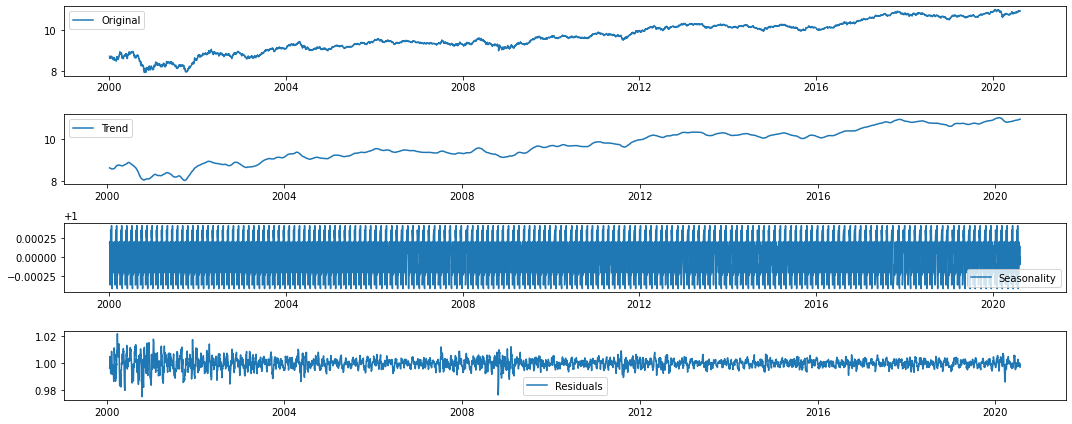

In [91]:
decomposition = seasonal_decompose(ts_log, model='multiplicative',period=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
# trend와 seasonality를 제거하고 난 나머지
# Trend+Seasonality+Residual = Original
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

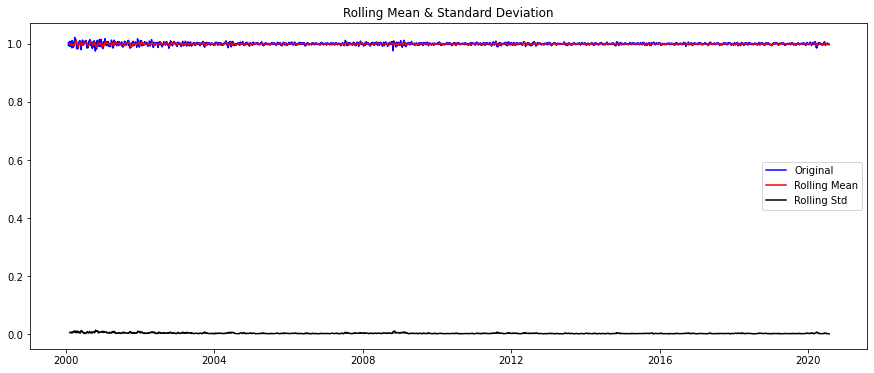

In [92]:
# Residual 안정성 확인
plot_rolling_statistics(residual)

In [93]:
# 이전에 직접 해준것보다 훨씬 유의미하게 나옴.
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.728531e+01
p-value                        5.748537e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.123000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


### ARIMA

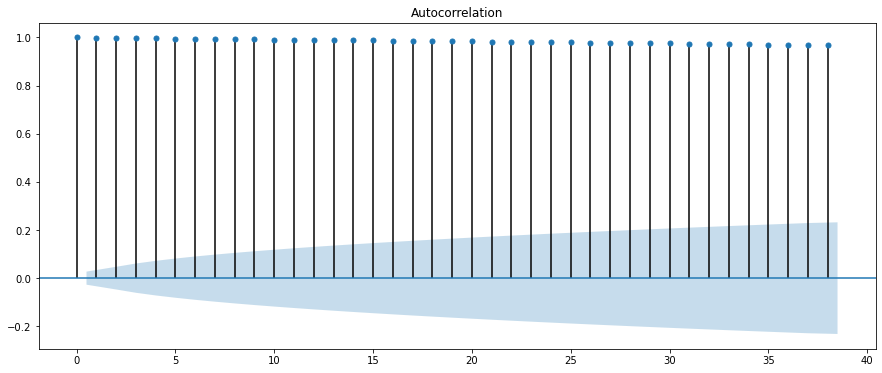

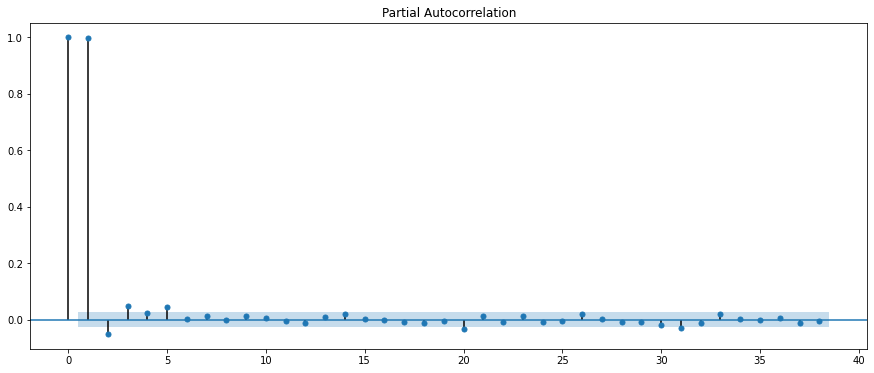

In [94]:
# ACF 그래프
# q에 적합한 값이 없어보여 q=0
plot_acf(ts_log)
# PACF 그래프: p=1이 가장 적합해보임
# 2 이상인 구간에서는 PACF가 거의 0에 가까워지고 있어서 데이터 상관도가 0이라고 보면 됨.
plot_pacf(ts_log)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -39.817874
p-value                           0.000000
#Lags Used                        3.000000
Number of Observations Used    5182.000000
Critical Value (1%)              -3.431613
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


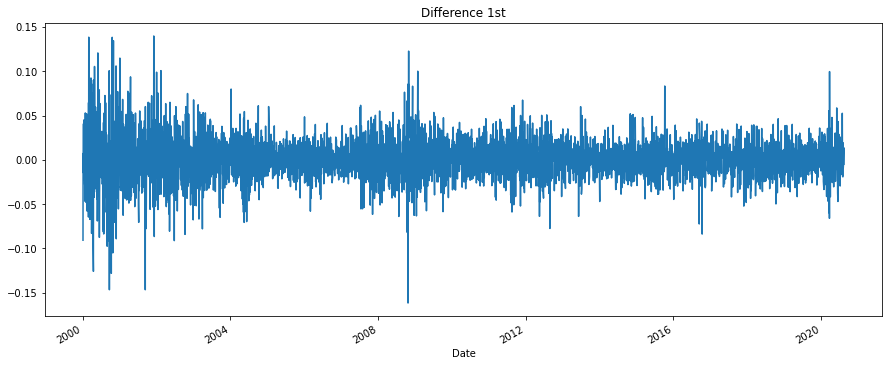

In [75]:
# d차 차분을 보고 시계열이 안정된 형태인지 확인
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

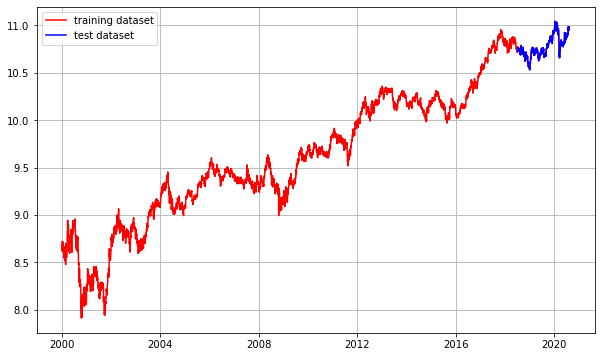

In [76]:
# 학습 테스트 9:1
train_data, test_data = ts_log[:int(len(ts_log)*0.9)], ts_log[int(len(ts_log)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

In [77]:
print(ts_log[:2])
print(train_data.shape)
print(test_data.shape)

Date
2000-01-04    8.717682
2000-01-05    8.626944
Name: Close, dtype: float64
(4668,)
(519,)


In [78]:
# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10983.285
Method:                       css-mle   S.D. of innovations              0.023
Date:                Thu, 13 Aug 2020   AIC                         -21960.569
Time:                        16:27:24   BIC                         -21941.224
Sample:                             1   HQIC                        -21953.765
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0004      0.000      1.205      0.228      -0.000       0.001
ar.L1.D.Close     0.0478      0.015      3.262      0.001       0.019       0.076
                                    Root

/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


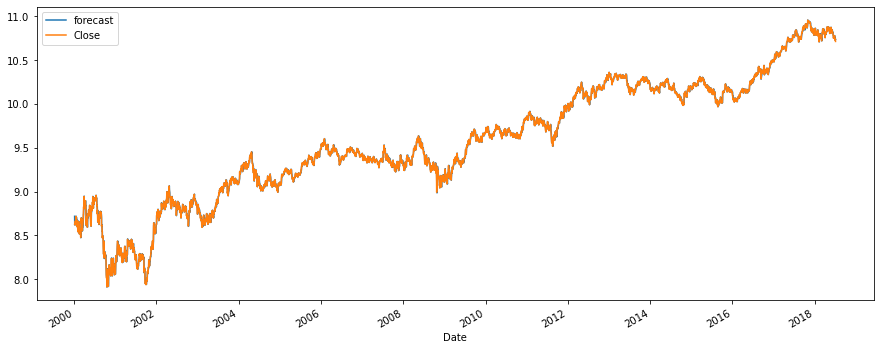

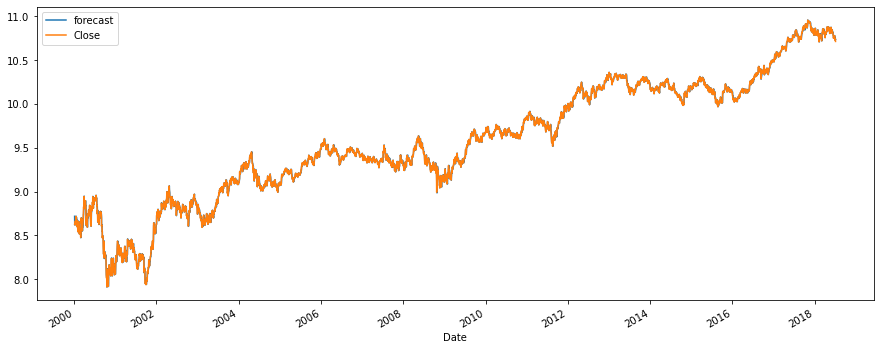

In [79]:
fitted_m.plot_predict()

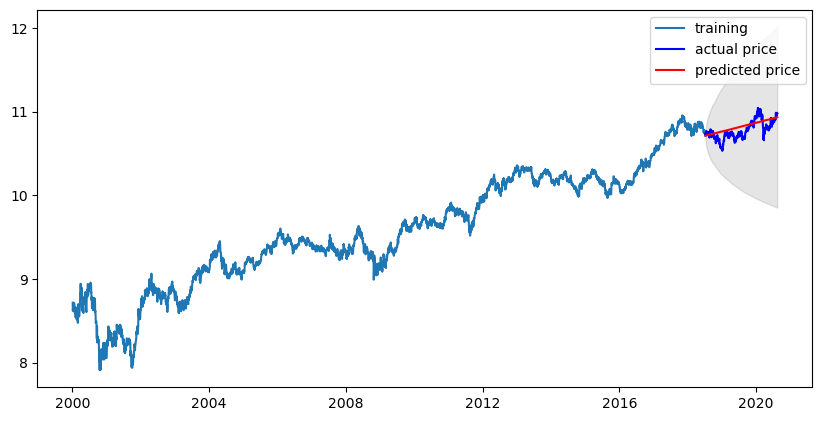

In [80]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [83]:
# 최종으로 오차 계산
mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  18517858.63179965
MAE:  3590.190001880987
RMSE:  4303.238156528134
MAPE: 7.68%


# Kakao Stock Prediction

In [102]:
filepath2 = os.getenv('HOME')+'/aiffel/stock_prediction/data/035720.KS.csv' 
df2 = pd.read_csv(filepath2, index_col='Date', parse_dates=True)
ts2 = df2['Close']
print(ts2.head())
print(ts2.shape)

Date
2000-02-11    273000.0
2000-02-14    247000.0
2000-02-15    217500.0
2000-02-16    243500.0
2000-02-17    243500.0
Name: Close, dtype: float64
(5159,)


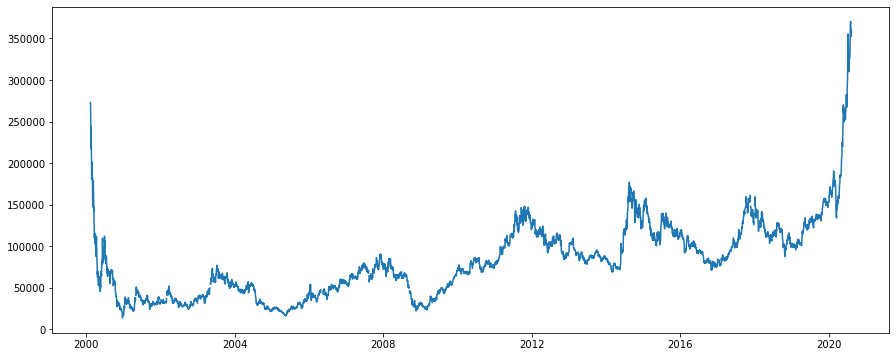

In [103]:
# 데이터 확인
rcParams['figure.figsize']=15,6

plt.plot(ts2)

In [104]:
# check the missing value
print(ts2[ts2.isna()])
# interpolation
ts2 = ts2.interpolate(method='time')

Date
2000-12-25   NaN
2000-12-27   NaN
2000-12-28   NaN
2000-12-29   NaN
2001-01-01   NaN
              ..
2017-11-16   NaN
2017-11-23   NaN
2018-01-02   NaN
2018-11-15   NaN
2019-11-14   NaN
Name: Close, Length: 114, dtype: float64


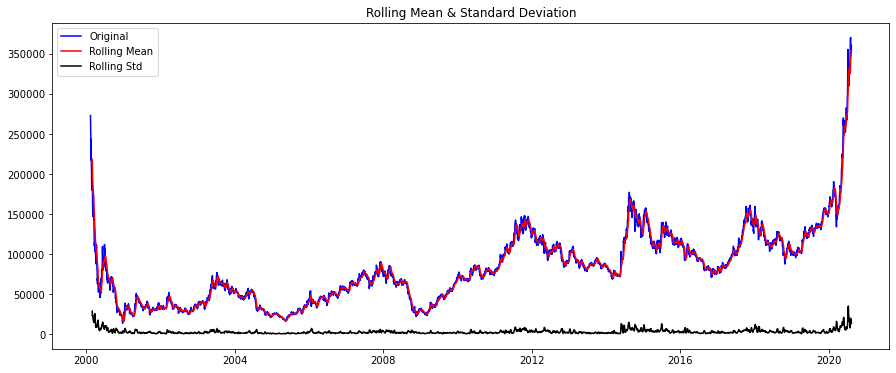

In [105]:
# 오르는 추세인데 딱히 규칙적 패턴은 없어보임.
plot_rolling_statistics(ts2,window=12)

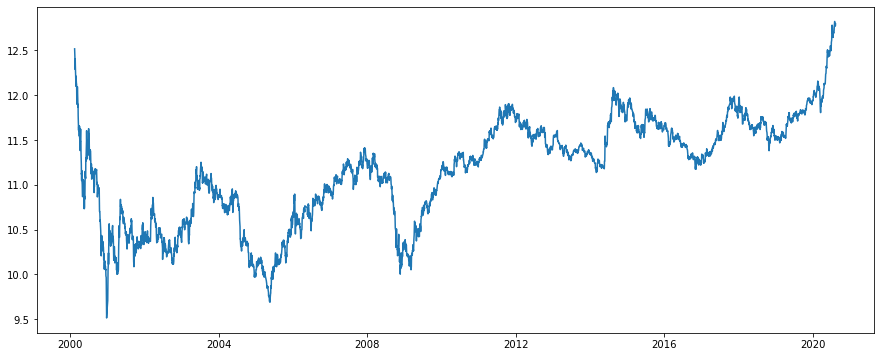

In [106]:
# 로그 함수로 변환
ts_log2 = np.log(ts2)
plt.plot(ts_log2)

In [107]:
# 제대로 변환되었는지 aumented dickey-fuller test 시행
# 아직 p-value보면 덜 변환됨.
augmented_dickey_fuller_test(ts_log2)

Results of Dickey-Fuller Test:
Test Statistic                   -1.671834
p-value                           0.445680
#Lags Used                        5.000000
Number of Observations Used    5153.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


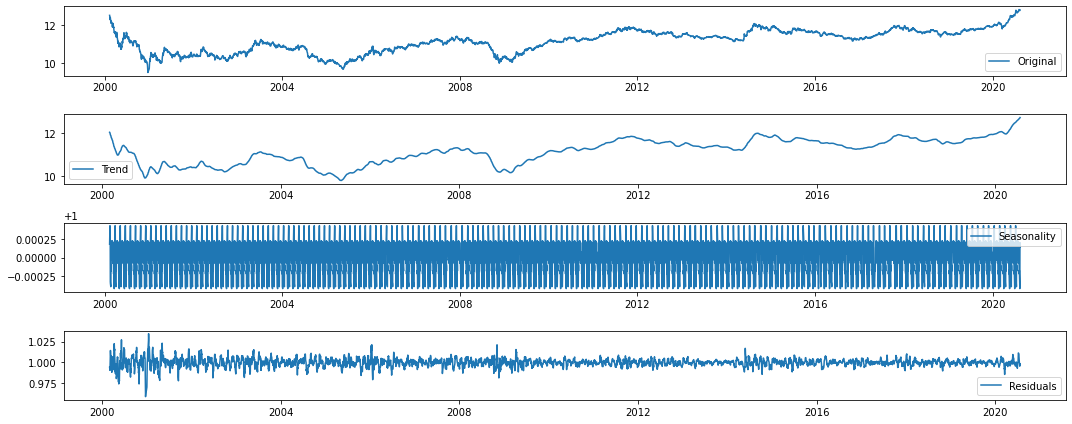

In [110]:
# Time Series Decomposition
decomposition2 = seasonal_decompose(ts_log2, model='multiplicative',period=30)

trend2 = decomposition2.trend
seasonal2 = decomposition2.seasonal
residual2 = decomposition2.resid

plt.subplot(411)
plt.plot(ts_log2, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend2, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal2,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
# trend와 seasonality를 제거하고 난 나머지
# Trend+Seasonality+Residual = Original
plt.plot(residual2, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

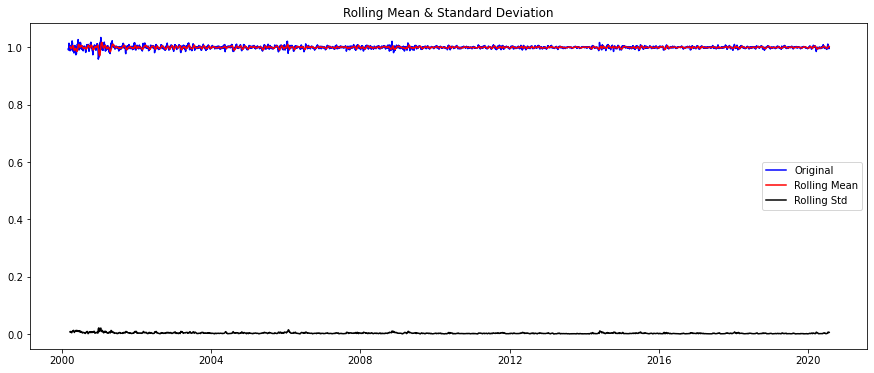

In [111]:
plot_rolling_statistics(residual2)

In [112]:
# 이전에 직접 해준것보다 훨씬 유의미하게 나옴.
residual2.dropna(inplace=True)
augmented_dickey_fuller_test(residual2)

Results of Dickey-Fuller Test:
Test Statistic                -1.770622e+01
p-value                        3.518811e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.095000e+03
Critical Value (1%)           -3.431634e+00
Critical Value (5%)           -2.862107e+00
Critical Value (10%)          -2.567072e+00
dtype: float64


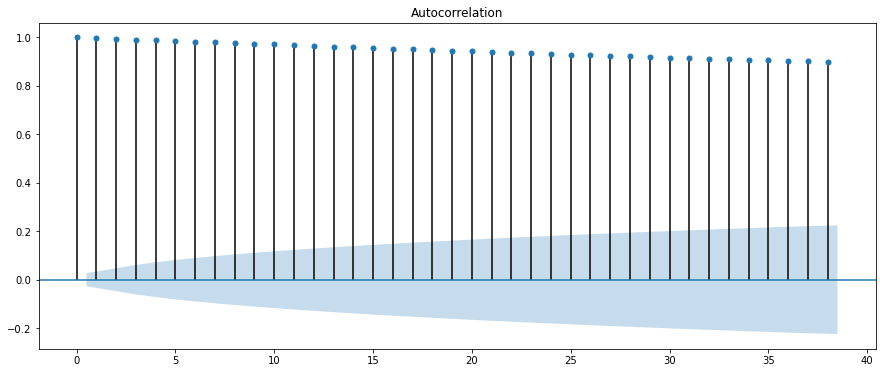

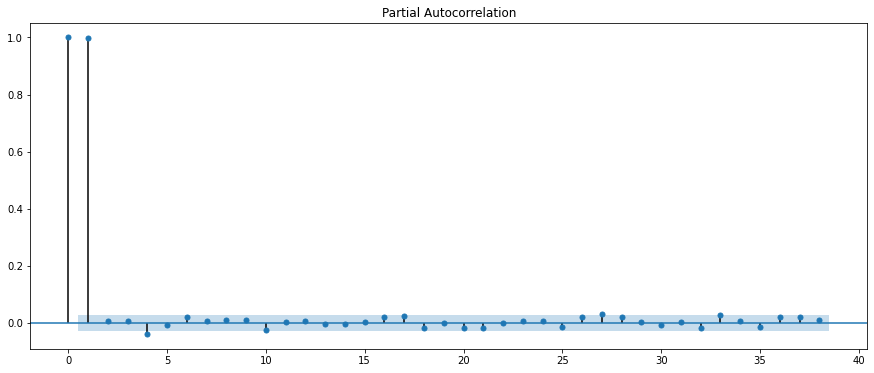

In [113]:
# ACF 그래프
plot_acf(ts_log2)
# PACF 그래프: p=1이 가장 적합해보임
# 2 이상인 구간에서는 PACF가 거의 0에 가까워지고 있어서 데이터 상관도가 0이라고 보면 됨.
plot_pacf(ts_log2)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                  -31.819284
p-value                           0.000000
#Lags Used                        4.000000
Number of Observations Used    5153.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


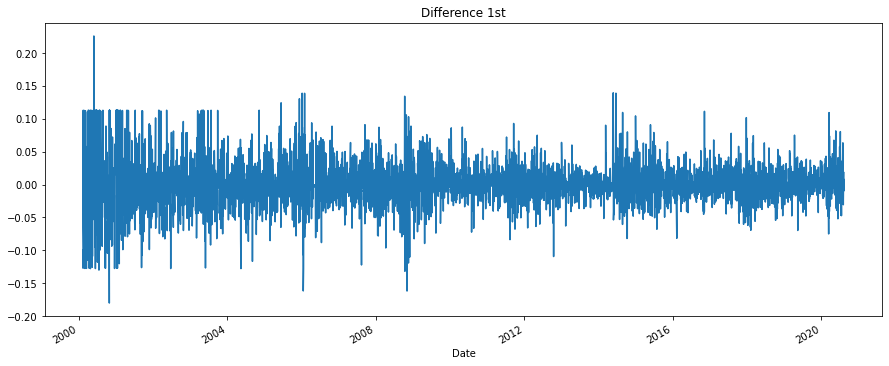

In [114]:
# d차 차분을 보고 시계열이 안정된 형태인지 확인
diff_1_2 = ts_log2.diff(periods=1).iloc[1:]
diff_1_2.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_2)

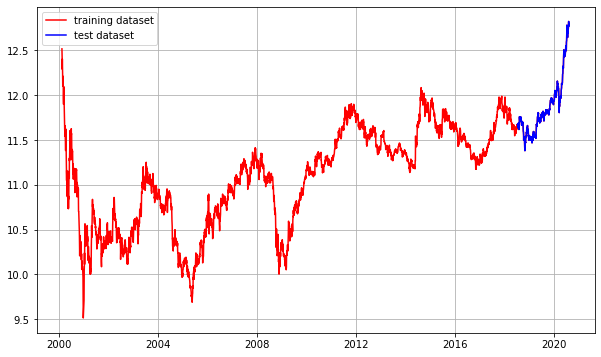

In [115]:
# 학습 테스트 9:1
train_data2, test_data2 = ts_log2[:int(len(ts_log2)*0.9)], ts_log2[int(len(ts_log2)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log2, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data2, c='b', label='test dataset')
plt.legend()

In [116]:
print(ts_log2[:2])
print(train_data2.shape)
print(test_data2.shape)

Date
2000-02-11    12.517227
2000-02-14    12.417144
Name: Close, dtype: float64
(4643,)
(516,)


In [131]:
# Build Model
model2 = ARIMA(train_data2, order=(1, 1, 0))  
fitted_m2 = model2.fit(disp=-1)  
print(fitted_m2.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4642
Model:                 ARIMA(1, 1, 0)   Log Likelihood                9142.540
Method:                       css-mle   S.D. of innovations              0.034
Date:                Thu, 13 Aug 2020   AIC                         -18279.079
Time:                        17:14:07   BIC                         -18259.751
Sample:                             1   HQIC                        -18272.279
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.001     -0.365      0.715      -0.001       0.001
ar.L1.D.Close     0.0152      0.015      1.032      0.302      -0.014       0.044
                                    Root

/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


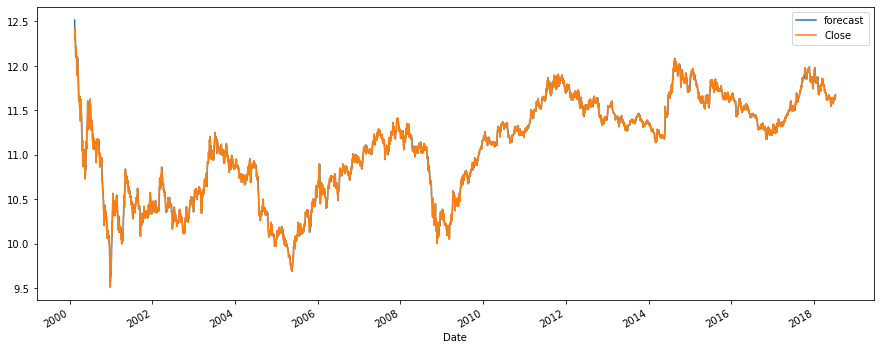

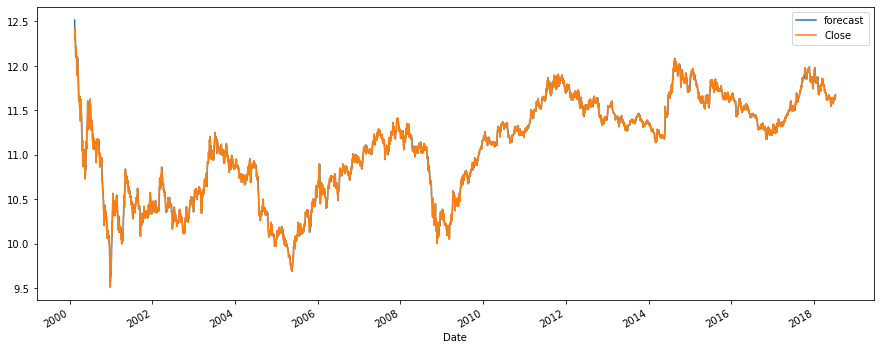

In [132]:
fitted_m2.plot_predict()

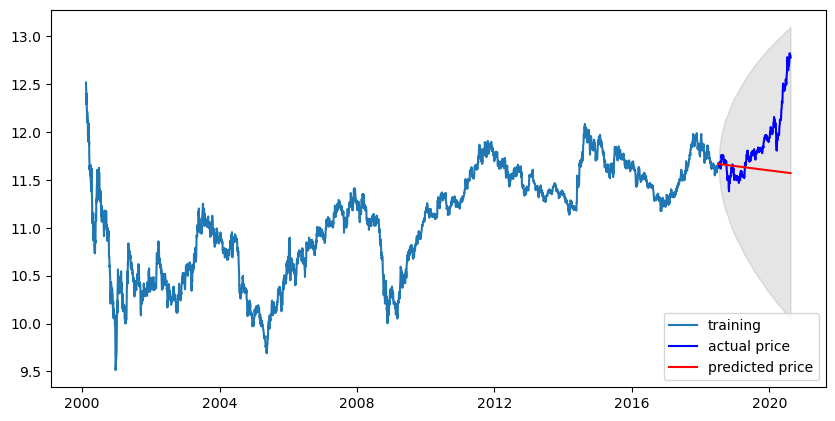

In [133]:

# Forecast : 결과가 fc에 담깁니다. 
fc2, se2, conf2 = fitted_m2.forecast(len(test_data2), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series2 = pd.Series(fc2, index=test_data2.index)   # 예측결과
lower_series2 = pd.Series(conf2[:, 0], index=test_data2.index)  # 예측결과의 하한 바운드
upper_series2 = pd.Series(conf2[:, 1], index=test_data2.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data2, label='training')
plt.plot(test_data2, c='b', label='actual price')
plt.plot(fc_series2, c='r',label='predicted price')
plt.fill_between(lower_series2.index, lower_series2, upper_series2, color='k', alpha=.10)
plt.legend()
plt.show()

In [134]:
# 최종으로 오차 계산
mse2 = mean_squared_error(np.exp(test_data2), np.exp(fc2))
print('MSE: ', mse2)

mae2 = mean_absolute_error(np.exp(test_data2), np.exp(fc2))
print('MAE: ', mae2)

rmse2 = math.sqrt(mean_squared_error(np.exp(test_data2), np.exp(fc2)))
print('RMSE: ', rmse2)

mape2 = np.mean(np.abs(np.exp(fc2) - np.exp(test_data2))/np.abs(np.exp(test_data2)))
print('MAPE: {:.2f}%'.format(mape2*100))

MSE:  5747219941.850224
MAE:  46195.752925678804
RMSE:  75810.42106366527
MAPE: 23.32%


# LG Display Stock Prediction

In [136]:
filepath3 = os.getenv('HOME')+'/aiffel/stock_prediction/data/LPL.csv' 
df3 = pd.read_csv(filepath3, index_col='Date', parse_dates=True)
ts3 = df3['Close']
print(ts3.head())
print(ts3.shape)

Date
2004-07-22    14.05
2004-07-23    14.20
2004-07-26    14.09
2004-07-27    14.45
2004-07-28    14.40
Name: Close, dtype: float64
(4044,)


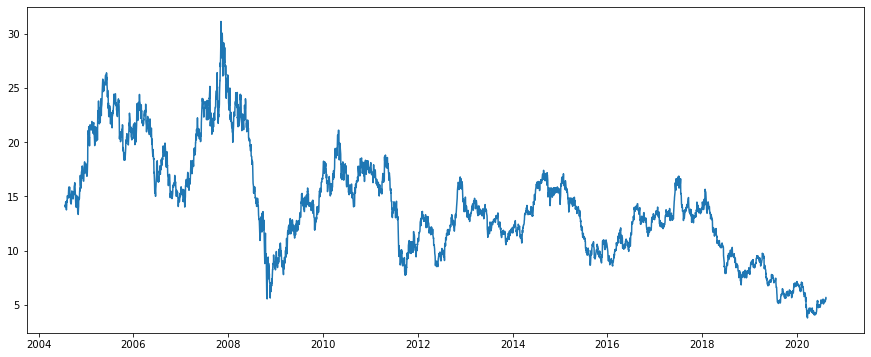

In [137]:
# 데이터 확인
# 떨어지는 추세
rcParams['figure.figsize']=15,6

plt.plot(ts3)

In [138]:
# check the missing value
print(ts3[ts3.isna()])
# interpolation
ts3 = ts3.interpolate(method='time')

Series([], Name: Close, dtype: float64)


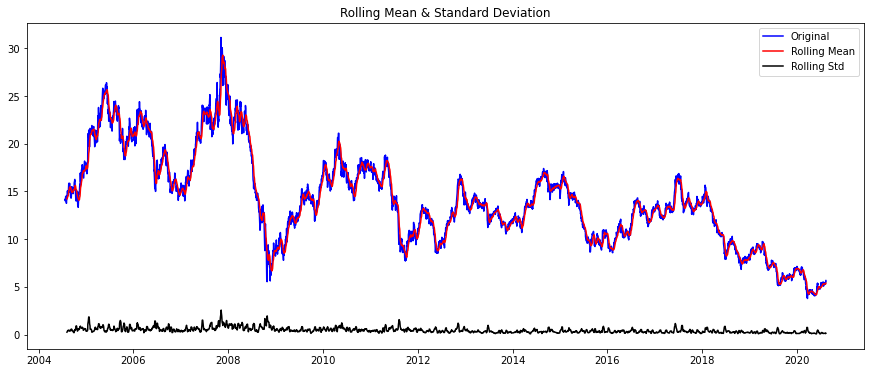

In [142]:
# 오르는 추세인데 딱히 규칙적 패턴은 없어보임.
plot_rolling_statistics(ts3,window=12)

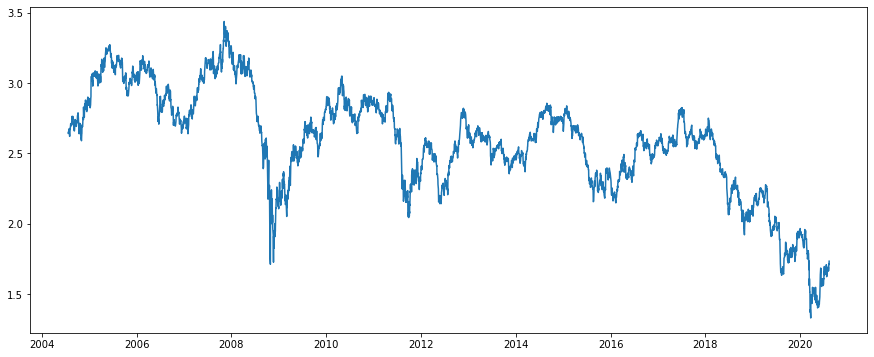

In [143]:
# 로그 함수로 변환
ts_log3 = np.log(ts3)
plt.plot(ts_log3)

In [144]:
# 제대로 변환되었는지 aumented dickey-fuller test 시행
# 아직 p-value보면 덜 변환됨.
augmented_dickey_fuller_test(ts_log3)

Results of Dickey-Fuller Test:
Test Statistic                   -1.724947
p-value                           0.418307
#Lags Used                       20.000000
Number of Observations Used    4023.000000
Critical Value (1%)              -3.431977
Critical Value (5%)              -2.862259
Critical Value (10%)             -2.567153
dtype: float64


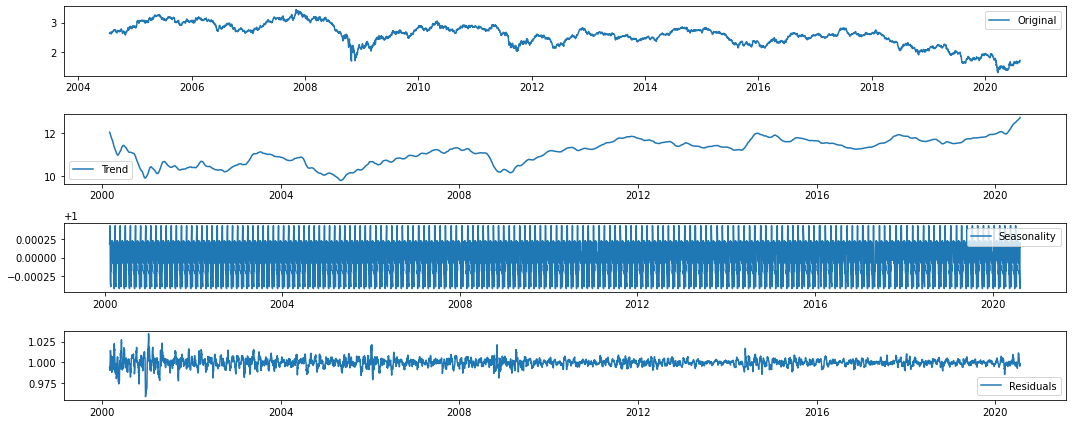

In [145]:
# Time Series Decomposition
decomposition3 = seasonal_decompose(ts_log3, model='multiplicative',period=30)

trend3 = decomposition2.trend
seasonal3 = decomposition2.seasonal
residual3 = decomposition2.resid

plt.subplot(411)
plt.plot(ts_log3, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend3, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal3,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
# trend와 seasonality를 제거하고 난 나머지
# Trend+Seasonality+Residual = Original
plt.plot(residual3, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

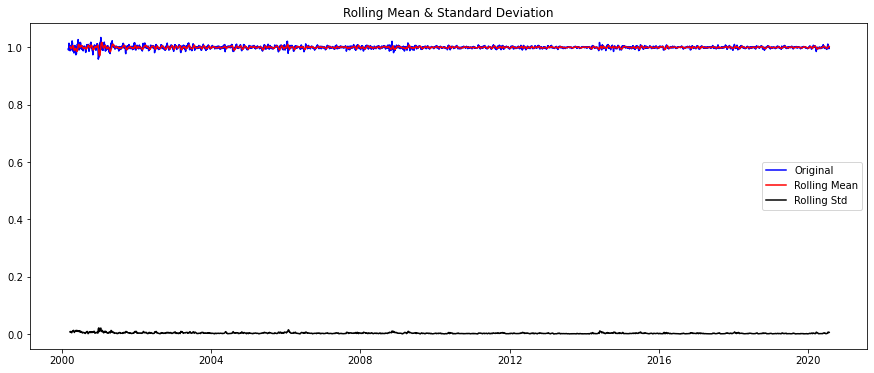

In [146]:
plot_rolling_statistics(residual3)

In [147]:
# residual check
residual3.dropna(inplace=True)
augmented_dickey_fuller_test(residual3)

Results of Dickey-Fuller Test:
Test Statistic                -1.770622e+01
p-value                        3.518811e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.095000e+03
Critical Value (1%)           -3.431634e+00
Critical Value (5%)           -2.862107e+00
Critical Value (10%)          -2.567072e+00
dtype: float64


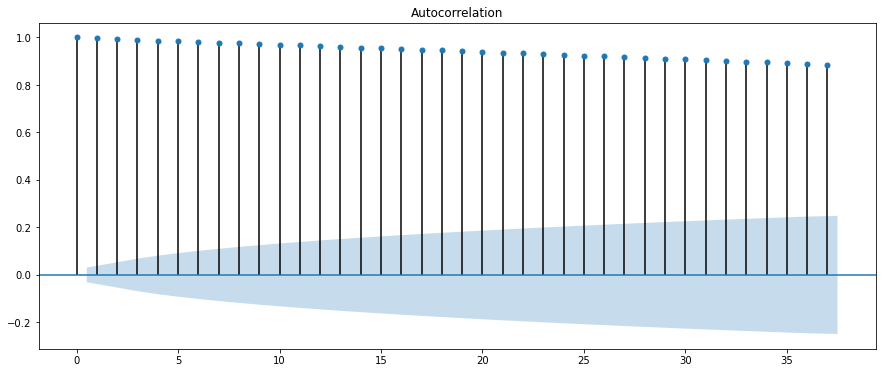

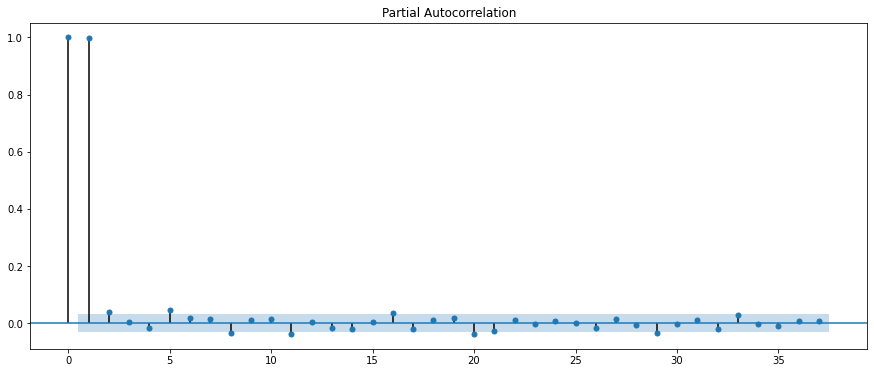

In [151]:
# ARIMA
# ACF 그래프
plot_acf(ts_log3)
# PACF 그래프: p=1이 가장 적합해보임
# 2 이상인 구간에서는 PACF가 거의 0에 가까워지고 있어서 데이터 상관도가 0이라고 보면 됨.
plot_pacf(ts_log3)
plt.show()

Results of Dickey-Fuller Test:
Test Statistic                -1.371373e+01
p-value                        1.223940e-25
#Lags Used                     1.900000e+01
Number of Observations Used    4.023000e+03
Critical Value (1%)           -3.431977e+00
Critical Value (5%)           -2.862259e+00
Critical Value (10%)          -2.567153e+00
dtype: float64


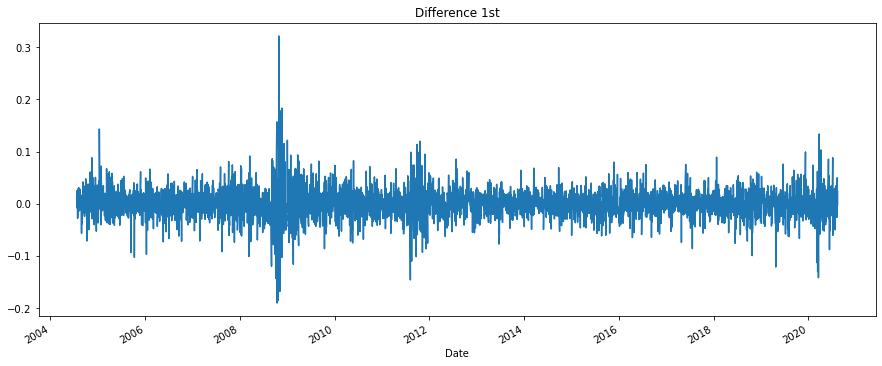

In [152]:
# d차 차분을 보고 시계열이 안정된 형태인지 확인 => 차분함.
diff_1_3 = ts_log3.diff(periods=1).iloc[1:]
diff_1_3.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_3)

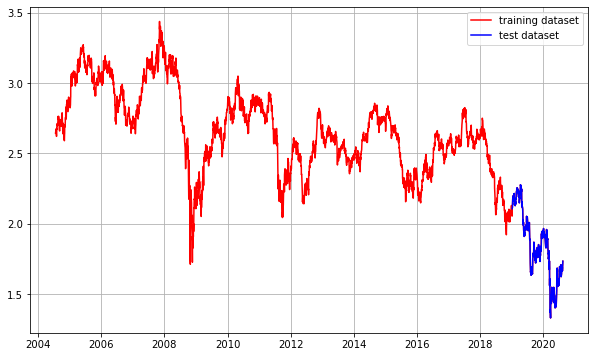

In [153]:
# 학습 테스트 9:1
train_data3, test_data3 = ts_log3[:int(len(ts_log3)*0.9)], ts_log3[int(len(ts_log3)*0.9):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log3, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data3, c='b', label='test dataset')
plt.legend()

In [154]:
print(ts_log3[:2])
print(train_data3.shape)
print(test_data3.shape)

Date
2004-07-22    2.642622
2004-07-23    2.653242
Name: Close, dtype: float64
(3639,)
(405,)


                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 3638
Model:                 ARIMA(1, 1, 0)   Log Likelihood                7791.111
Method:                       css-mle   S.D. of innovations              0.028
Date:                Thu, 13 Aug 2020   AIC                         -15576.222
Time:                        17:29:19   BIC                         -15557.625
Sample:                             1   HQIC                        -15569.598
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0002      0.000     -0.357      0.721      -0.001       0.001
ar.L1.D.Close    -0.0425      0.017     -2.566      0.010      -0.075      -0.010
                                    Root

/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel0036/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


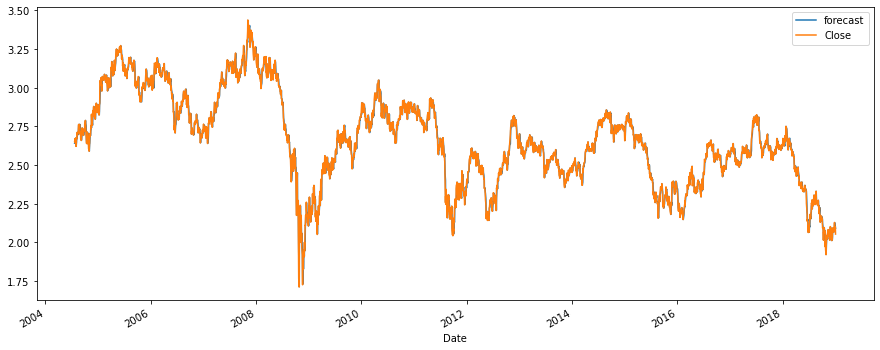

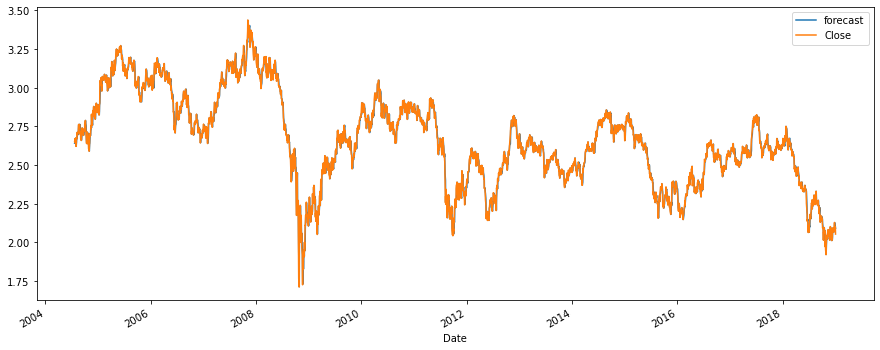

In [155]:
# Build Model
model3 = ARIMA(train_data3, order=(1, 1, 0))  
fitted_m3 = model3.fit(disp=-1)  
print(fitted_m3.summary())

fitted_m3.plot_predict()

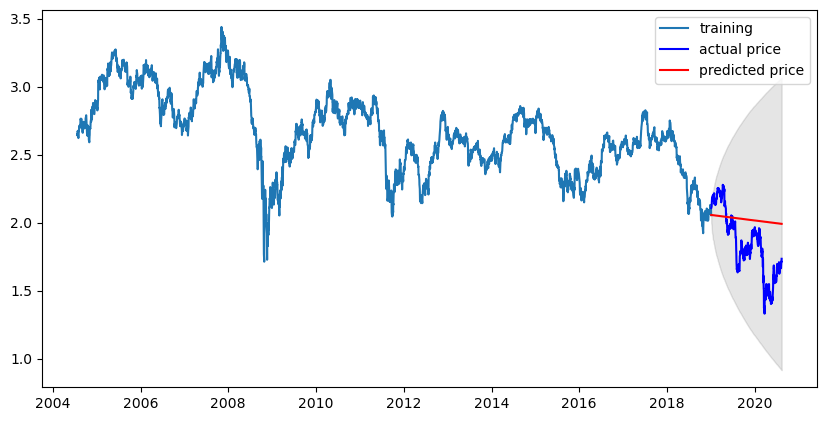

In [158]:
# Forecast : 결과가 fc에 담깁니다. 
fc3, se3, conf3 = fitted_m3.forecast(len(test_data3), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series3 = pd.Series(fc3, index=test_data3.index)   # 예측결과
lower_series3 = pd.Series(conf3[:, 0], index=test_data3.index)  # 예측결과의 하한 바운드
upper_series3 = pd.Series(conf3[:, 1], index=test_data3.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data3, label='training')
plt.plot(test_data3, c='b', label='actual price')
plt.plot(fc_series3, c='r',label='predicted price')
plt.fill_between(lower_series3.index, lower_series3, upper_series3, color='k', alpha=.10)
plt.legend()
plt.show()

In [159]:
# 최종으로 오차 계산
mse3 = mean_squared_error(np.exp(test_data3), np.exp(fc3))
print('MSE: ', mse3)

mae3 = mean_absolute_error(np.exp(test_data3), np.exp(fc3))
print('MAE: ', mae3)

rmse3 = math.sqrt(mean_squared_error(np.exp(test_data3), np.exp(fc3)))
print('RMSE: ', rmse3)

mape3 = np.mean(np.abs(np.exp(fc3) - np.exp(test_data3))/np.abs(np.exp(test_data3)))
print('MAPE: {:.2f}%'.format(mape3*100))

MSE:  3.1423045093055464
MAE:  1.5487763422038086
RMSE:  1.7726546503212481
MAPE: 27.87%


# Conclusion
- 코로나라는 예측하지 못한 변수를 만나면서 주식 예측력이 떨어진 것 같음.
- 삼성 같은 경우에는 대형주이고 다른 주식들에 비해 큰 영향을 받지 않아 예측력이 10% 미만으로 나온 것 같다.
- 카카오나 lg 디스플레이는 코로나, 중국 등의 영향을 받아서 너무 올라가거나 너무 떨어져서 예측하기 힘들었던 것 같다.
- 주식은 외부 요인에 큰 영향을 받기 때문에 외부요인을 적용하여 실시간으로 예측할 수 있는 프로그램을 만들면 예측력이 더 좋아질 것 같다.